# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 <br>
Number of users: 256,059 <br>
Number of products: 74,258 <br>
Timespan: Oct 1999 - Oct 2012 <br>
Number of Attributes/Columns in data: 10 <br> 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


## Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


Ques - How to determine if a review is positive or negative?

Ans -  We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy 
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.stem import LancasterStemmer, PorterStemmer, WordNetLemmatizer, wordnet
from nltk.corpus import stopwords
import seaborn as sns
import os
import gensim
import re 
import sqlite3
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, r2_score, confusion_matrix, classification_report

from gensim.models import keyedvectors, KeyedVectors
from gensim.models import Word2Vec, word2vec

from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import sqlalchemy


import pyodbc #pyodbc is an open source Python module that makes accessing ODBC databases simple #https://github.com/mkleehammer/pyodbc/wiki
#using pyodbc we can connect to any database.
import mysql.connector

In [2]:
#creating a new sqlite database- If i create a .db file also then also its a sqlite database. 
#We can manage the contents using #SQLlitestudio
conn = sqlite3.connect(r'F:\MySQL\SQL Files\Database\amazon_review.db')  #using this command we can create a sqlite db also
c = conn.cursor()

#Create Table SQL
create_table_sql = """CREATE TABLE REVIEW103(
                    Id INT PRIMARY KEY NOT NULL,
                    ProductId TEXT,
                    UserId TEXT,
                    ProfileName TEXT,
                    HelpfulnessNumerator INT,
                    HelpfulnessDenominator INT,
                    Score INT,
                    TIME INT,
                    Summary TEXT,
                    Text TEXT)"""

#CREATING TABLE IN DATABSE

c.execute(create_table_sql)

In [3]:
#PRINT TABLE NMAES IN DATABASE
query = "SELECT name FROM sqlite_master WHERE type ='table'"
table_names = c.execute(query)
table_names.fetchall()

[('REVIEWS',),
 ('REVIEW',),
 ('REVIEW2',),
 ('REVIEW3',),
 ('REVIEW4',),
 ('REVIEW5',),
 ('REVIEW6',),
 ('REVIEW7',),
 ('REVIEW8',),
 ('REVIEW9',),
 ('REVIEW10',),
 ('REVIEW11',),
 ('REVIEW12',),
 ('REVIEW13',),
 ('REVIEW14',),
 ('REVIEW15',),
 ('REVIEW16',),
 ('REVIEW101',),
 ('REVIEW102',),
 ('REVIEW103',)]

In [4]:
#Importing the dataset
data = pd.read_csv(r"C:\Users\user-pc\AppliedAi\3.0\3.1\amazon-fine-food-reviews\Reviews.csv")

In [5]:
#Insert dataframe to the sqlite database - This i need to work on 

In [5]:
####We have another method to load data in db using sqlalchemy

#SQLALCHEMY - it allows us to generate SQL queries using python codes.It works on all database file. To connect to a db we need 
#to talk to it and an engine provide a common interface. To create an engine we use create_engine command

engine = sqlalchemy.create_engine(r'sqlite:///F:\MySQL\SQL Files\Database\amazon_review.db') #this is only to connect to a db. we cannot create a db.
connection = engine.connect()
print(engine.table_names())

['REVIEW', 'REVIEW10', 'REVIEW101', 'REVIEW102', 'REVIEW103', 'REVIEW11', 'REVIEW12', 'REVIEW13', 'REVIEW14', 'REVIEW15', 'REVIEW16', 'REVIEW2', 'REVIEW3', 'REVIEW4', 'REVIEW5', 'REVIEW6', 'REVIEW7', 'REVIEW8', 'REVIEW9', 'REVIEWS']


In [6]:
conn = sqlite3.connect(r"C:\Users\user-pc\AppliedAi\3.0\3.1\amazon-fine-food-reviews\database.sqlite")
#c = conn.cursor()
#count = c.execute("select count(*) from Reviews")
#print(count.fetchall())

In [7]:
dataset = pd.read_sql_query("Select * from Reviews", conn) #it returns dataframe

In [8]:
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Basic Data Analysis

In [9]:
print("The shape of data is :")
print(data.shape)

The shape of data is :
(568454, 10)


In [10]:
#The count of score in the Amazon review dataset
print("The count of elements in \"score\" column is \n{}".format(data['Score'].value_counts()))

The count of elements in "score" column is 
5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


In [11]:
print("The number of null values in dataframe is:")
data.isna().sum()

The number of null values in dataframe is:


Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### Removing the data with neutral score (score = 3)

In [13]:
#Dropping the dataset where score = 3
reviews_data = pd.read_sql("Select * from Reviews where score !=3", conn)

In [14]:
print("The shape of data is :")
print(reviews_data.shape)

The shape of data is :
(525814, 10)


In [15]:
#The count of score in the Amazon review dataset
print("The count of elements in \"score\" column is : \n{}".format(reviews_data['Score'].value_counts()))

The count of elements in "score" column is : 
5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64


In [16]:
print("The number of null values in dataframe is:")
reviews_data.isna().sum()

The number of null values in dataframe is:


Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

### Creating target variable based on score <3 = negative review (0) and score >3 = positive review (1)

In [17]:
reviews_data["Score"] = reviews_data["Score"].apply(lambda x: 0 if x <3 else 1)

The number of pos reviews and neg reviews are :
1    443777
0     82037
Name: Score, dtype: int64


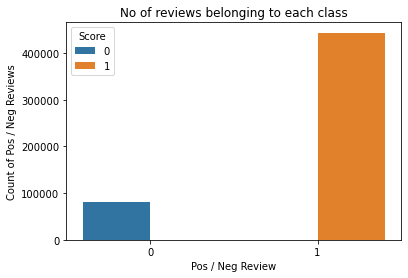

In [18]:
print("The number of pos reviews and neg reviews are :")
print(reviews_data.Score.value_counts())

sns.countplot(reviews_data["Score"], hue = reviews_data["Score"])
plt.xlabel("Pos / Neg Review")
plt.ylabel("Count of Pos / Neg Reviews")
plt.title("No of reviews belonging to each class")
plt.show()

In [19]:
#no of times each user has given the more that one review
review_count = (reviews_data.groupby(by = "UserId")["UserId"].count()[reviews_data.groupby(by = "UserId")["UserId"].count()>1])
print(review_count)

UserId
#oc-R115TNMSPFT9I7    2
#oc-R11D9D7SHXIJB9    3
#oc-R11DNU2NBKQ23Z    2
#oc-R11O5J5ZVQE25C    3
#oc-R12KPBODL2B5ZD    2
                     ..
AZZNK89PXD006         6
AZZTH6DJ0KSIP         3
AZZU1VEO8KUXH         3
AZZU4D6TZ2L6J         2
AZZV9PDNMCOZW         3
Name: UserId, Length: 75346, dtype: int64


In [20]:
#User who has given max review
print("The user with max review count is :",review_count[review_count==425])

The user with max review count is : UserId
A3OXHLG6DIBRW8    425
Name: UserId, dtype: int64


In [21]:
reviews_count = pd.read_sql_query("Select UserId, ProductId, ProfileName, Score, Time, Summary, Text, count(UserId) from Reviews group by UserId having count(UserId)>1", conn)
reviews_count.head()

,UserId,ProductId,ProfileName,Score,Time,Summary,Text,count(UserId)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...,2


In [22]:
print("The shape of reviews_count is :",reviews_count.shape)

The shape of reviews_count is : (80668, 8)


In [23]:
reviews_count.loc[reviews_count['UserId']=="AZZNK89PXD006"]

,UserId,ProductId,ProfileName,Score,Time,Summary,Text,count(UserId)
80663,AZZNK89PXD006,B0039GMZZK,Etude,5,1269648000,"Limited Edition, Unlimited Flavor!",Regular Chocolate Pocky is good on its own but...,6


#### #check for duplicate data

In [24]:
reviews_data.duplicated(subset=['UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary','Text']).value_counts()

False    366392
True     159422
dtype: int64

#### #Dropping the duplicate data

In [25]:
reviews_data.drop_duplicates(subset=['UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary','Text']\
                            , keep="first", inplace= True)

print("The number of O and 1 data are :")
reviews_data.Score.value_counts()

The number of O and 1 data are :


1    308681
0     57711
Name: Score, dtype: int64

#### #Check for the data where Helpfullness numerator > Helpfullness denominator. If it exists then its absurd data

In [26]:
print("The no of datapoints where where Helpfullness numerator > Helpfullness denominator : ")
print((reviews_data['HelpfulnessNumerator']>reviews_data['HelpfulnessDenominator']).value_counts())

reviews_data.loc[(reviews_data['HelpfulnessNumerator'] > reviews_data['HelpfulnessDenominator'])]

The no of datapoints where where Helpfullness numerator > Helpfullness denominator : 
False    366390
True          2
dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


#### #Dropping the rows with Helpfullness numerator > Helpfullness denominator

In [27]:
reviews_data.drop(index=[41159, 59301], axis=0, inplace=True)

In [28]:
print("The actual shape of the reviews data is:",reviews_data.shape)

The actual shape of the reviews data is: (366390, 10)


In [29]:
reviews_data["Score"].replace(to_replace=[0,1], value=["negative", "positive"], inplace=True)
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Feature Engineering

### 1. Making a column with word count - Summary count and Text Count

In [30]:
#Summary Count
reviews_data['Summary_count'] = reviews_data['Summary'].apply(lambda x : len(x.split()))

#Text Count
reviews_data['Text_count'] = reviews_data['Text'].apply(lambda x : len(x.split()))

### 2. Making a column with length - Summary length and Text length

In [31]:
#Summary length
reviews_data['Summary_length'] = reviews_data['Summary'].apply(lambda x : len(x))

#Text length
reviews_data['Text_length'] = reviews_data['Text'].apply(lambda x : len(x))

### 3. Making a new column - "Comment" combining Text and Summary 

In [32]:
#New column - "Comment"
reviews_data['Comment'] = reviews_data['Summary'] + " "+ reviews_data['Text']

In [33]:
#Comment count
reviews_data['Comment_count'] = reviews_data['Comment'].apply(lambda x : len(x.split()))

#Comment length
reviews_data['Comment_length'] = reviews_data['Comment'].apply(lambda x : len(x))

reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Summary_count,Text_count,Summary_length,Text_length,Comment,Comment_count,Comment_length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,4,48,21,263,Good Quality Dog Food I have bought several of...,52,285
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,3,31,17,190,Not as Advertised Product arrived labeled as J...,34,208
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,4,94,21,509,"""Delight"" says it all This is a confection tha...",98,531
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2,41,14,219,Cough Medicine If you are looking for the secr...,43,234
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2,27,11,140,Great taffy Great taffy at a great price. The...,29,152


#### Splitting the dataset - 50000 pos review data and 50000 neg review data for training and testing purpose.

In [35]:
# Positive and Negative reviewed Data

reviews_data_pos = reviews_data.loc[reviews_data['Score']== "positive"]
reviews_data_neg = reviews_data.loc[reviews_data['Score']== "negative"]

print("The shape of positive review data is:")
print(reviews_data_pos.shape)

print("\n")

print("The shape of negative review data is:")
print(reviews_data_neg.shape)

The shape of positive review data is:
(308679, 17)


The shape of negative review data is:
(57711, 17)


In [36]:
# Data to be used for model building purpose is - data_train and data_test will be used for testing purpose.

data_train = pd.concat([reviews_data_pos[0:50000], reviews_data_neg[0:50000]], ignore_index=True)
print("The shape of data that is used for modelling is",data_train.shape)

print("\n")

data_test = pd.concat([reviews_data_pos[50001:], reviews_data_neg[50000:]], ignore_index=True)
print("The shape of data that is used for testing is",data_test.shape)

The shape of data that is used for modelling is (100000, 17)


The shape of data that is used for testing is (266389, 17)


# Text processing

##### 1. Removing HTML tags
##### 2. Removing HTTP links
##### 3. Lowering of sentence
##### 4. Removing stopwords
##### 5. Revoming puncuations
##### 6. Removing words less the 3 characters
##### 7. Removing Alphanumeric and numeric characters. 
##### 8. Applying Lemmatization
##### 9. Applying stemming


### #Checking if HTML tags and HTTP links are present or not 

In [37]:
#Checking how many has HTML TAG
print("The count of comments which has HTML tags are : ")
print((data_train["Comment"].apply(lambda x: "Yes" if bool(re.search(r"<.{2,4}>", x))==True else "No")).value_counts())

print("\n")

#Checking how many comment has HTTP link
print("The count of comments which has HTTP link are : ")
(data_train["Comment"].apply(lambda x: "Yes" if bool(re.search(r"http://", x))==True else "No")).value_counts()

The count of comments which has HTML tags are : 
No     73180
Yes    26820
Name: Comment, dtype: int64


The count of comments which has HTTP link are : 


No     98004
Yes     1996
Name: Comment, dtype: int64

#### Rows with html tag = "Yes"- where html tag is present

In [38]:
html_tag = (data_train["Comment"].apply(lambda x: "Yes" if bool(re.search(r"<.{2,4}>", x))==True else "No"))
html_tag[html_tag=="Yes"].head()

8     Yes
14    Yes
17    Yes
20    Yes
21    Yes
Name: Comment, dtype: object

In [40]:
#An example of Comment that has an html tag present
data_train.iloc[8]['Comment']

"The Best Hot Sauce in the World I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [41]:
re.sub(r'<.{2,4}>', "", data_train.iloc[8]['Comment'])

"The Best Hot Sauce in the World I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!"

### #Checking if HTTP link are present or not 

In [42]:
print("The count of comments which has HTTP links are : ")
print((data_train["Comment"].apply(lambda x: "Yes" if bool(re.search(r"https|http", x))==True else "No")).value_counts())

The count of comments which has HTTP links are : 
No     98004
Yes     1996
Name: Comment, dtype: int64


#### Rows with http link = "Yes"- where http link is present

In [43]:
http_link_present = (data_train["Comment"].apply(lambda x: "Yes" if bool(re.search(r"https|http", x))==True else "No"))
http_link_present[http_link_present=="Yes"].head()

17     Yes
21     Yes
33     Yes
273    Yes
293    Yes
Name: Comment, dtype: object

In [44]:
#An example of Comment that has an http link present
data_train.iloc[17]['Comment']

'TWIZZLERS I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.<br />There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. <a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [45]:
#Removing http link using Beautiful soup
from bs4 import BeautifulSoup
soup = BeautifulSoup(data_train.iloc[17]['Comment'], "html.parser")
print(soup.find("a")['href'])
soup.get_text()

http://www.amazon.com/gp/product/B001GVISJM


'TWIZZLERS I bought these for my husband who is currently overseas. He loves these, and apparently his staff likes them also.There are generous amounts of Twizzlers in each 16-ounce bag, and this was well worth the price. Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)'

## Processing of Text

#### Removing http link and html tags

#### Lowercase and Removing Stopwords

### Saving List to the harddisk Using Pickle-  https://www.datacamp.com/community/tutorials/pickle-python-tutorial

In [46]:
#Loading the file back in a list - infile
import pickle

infile = open(r"G:\Projects\Amazon fine food review\Stopword_removed_list",'rb')
processed_text_pickled_level2 = pickle.load(infile)
infile.close()

In [47]:
processed_text_pickled_level2[0:50]

['good quality dog food bought several vitality canned dog food products found good quality. product looks like stew processed meat smells better. labrador finicky appreciates product better most.',
 '"delight" says confection around centuries. light, pillowy citrus gelatin nuts - case filberts. cut tiny squares liberally coated powdered sugar. tiny mouthful heaven. chewy, flavorful. highly recommend yummy treat. familiar story c.s. lewis\' "the lion, witch, wardrobe" - treat seduces edmund selling brother sisters witch.',
 'great taffy great taffy great price. wide assortment yummy taffy. delivery quick. taffy lover, deal.',
 'nice taffy got wild hair taffy ordered five pound bag. taffy enjoyable many flavors: watermelon, root beer, melon, peppermint, grape, etc. complaint bit much red/black licorice-flavored pieces (just particular favorites). me, kids, husband, lasted two weeks! would recommend brand taffy -- delightful treat.',
 "great! good expensive brands! saltwater taffy great 

#### Punctuation removal and Removal of words less than 3 characters in length, non english words and multiple spaces 

In [48]:
# Punctuation removal and Removal of words less than 3 characters in length, non english words and multiple spaces - 
#3nd level of preprocessing
from tqdm import tqdm
processed_text_level3 = []

for text in tqdm(processed_text_pickled_level2):
    
    text = ("").join(char for char in text if char not in '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')  ##string.punctuations
    text = (" ").join(word for word in text.split() if len(word)>2) # removal of words less than 3 characters
    text = re.sub(r"[^A-Za-z]+", " ", text) #removal of non english words
    text = re.sub(r"\s+", r" ", text) #Removal of multiple spaces
    
    processed_text_level3.append(text)

100%|████████████████████████████████| 100000/100000 [00:18<00:00, 5394.29it/s]


#### Lemmatization and Stemming 

In [49]:
from nltk.stem import wordnet, WordNetLemmatizer, LancasterStemmer, PorterStemmer
word_lem = WordNetLemmatizer()
pst_stem = PorterStemmer()

processed_text_final = []

for text in tqdm(processed_text_level3):
    text = (" ").join(word_lem.lemmatize(word) for word in text.split()) ##Lemmatization
    text = (" ").join(pst_stem.stem(word) for word in text.split())   ##Stemming
    
    processed_text_final.append(text)

100%|█████████████████████████████████| 100000/100000 [05:38<00:00, 295.60it/s]


In [59]:
print("\"Processed_text_final - List\" is the final text that we get after processing of Text") 

"Processed_text_final - List" is the final text that we get after processing of Text


#### New column - "Processed_text " column is created to save the processed text

In [50]:
data_train.shape

(100000, 17)

In [51]:
data_train['processed_text'] = processed_text_final

print("The shape of new df is", data_train.shape)

The shape of new df is (100000, 18)


In [52]:
#Converting "score" column to 1/0 for Positive and Negative respectively

data_train['Score'] = data_train["Score"].apply(lambda x : 1 if x =="positive" else 0)

# Feature Engineering

## 1. Bag of Words - Binary

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,3), binary=True, stop_words="english")

#Fiting the data- it fits the data and find the vocabulary
bow_binary = count_vect.fit(data_train['processed_text'])


In [54]:
count_vect.get_params

<bound method BaseEstimator.get_params of CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)>

In [55]:
print("The number of features in BOW - Binary are",len(bow_binary.get_feature_names()))

The number of features in BOW - Binary are 4522963


In [56]:
print("The top 10 items in vocabulary is :")
[v for v in bow_binary.vocabulary_.items()][0:10]

The top 10 items in vocabulary is :


[('good', 1657889),
 ('qualiti', 3134677),
 ('dog', 1147537),
 ('food', 1522169),
 ('bought', 429395),
 ('sever', 3487171),
 ('vital', 4322690),
 ('product', 3054496),
 ('look', 2304013),
 ('like', 2204649)]

In [57]:
## Transforming the data - transform outputs the sparse matrix of indices aong with the no. of times each word occur in the index

data_train["processed_text"][4]
bow4 = bow_binary.transform([data_train["processed_text"][4]])
#print(bow4)

print("The datatype of bow4 is :",type(bow4))

print("The dimension of bow4 is :",bow4.ndim)
print("The shape of bow4 is : ",bow4.shape)
print(bow4)

The datatype of bow4 is : <class 'scipy.sparse.csr.csr_matrix'>
The dimension of bow4 is : 2
The shape of bow4 is :  (1, 4522963)
  (0, 290591)	1
  (0, 290794)	1
  (0, 290795)	1
  (0, 463603)	1
  (0, 471266)	1
  (0, 471267)	1
  (0, 574676)	1
  (0, 577443)	1
  (0, 577444)	1
  (0, 579055)	1
  (0, 579056)	1
  (0, 579517)	1
  (0, 579521)	1
  (0, 682568)	1
  (0, 682745)	1
  (0, 682751)	1
  (0, 1318156)	1
  (0, 1319181)	1
  (0, 1346764)	1
  (0, 1347216)	1
  (0, 1347263)	1
  (0, 1351176)	1
  (0, 1351178)	1
  (0, 1468830)	1
  (0, 1494093)	1
  :	:
  (0, 3389222)	1
  (0, 3475461)	1
  (0, 3475796)	1
  (0, 3475797)	1
  (0, 3622849)	1
  (0, 3623141)	1
  (0, 3623157)	1
  (0, 3790890)	1
  (0, 3792250)	1
  (0, 3792285)	1
  (0, 3894431)	1
  (0, 3894557)	1
  (0, 3894558)	1
  (0, 4014992)	1
  (0, 4015100)	1
  (0, 4015104)	1
  (0, 4105488)	1
  (0, 4106223)	1
  (0, 4106224)	1
  (0, 4309478)	1
  (0, 4310510)	1
  (0, 4310511)	1
  (0, 4477588)	1
  (0, 4477830)	1
  (0, 4477845)	1


In [58]:
#Transforming the data

binary_bag_of_words = bow_binary.transform(data_train['processed_text'])

print("The shape of BInary Bag of Words is : ",binary_bag_of_words.shape)

The shape of BInary Bag of Words is :  (100000, 4522963)


In [59]:
#Amount of non zero occurances

print("The number of non zero occurances are:", binary_bag_of_words.nnz)

Sparcity = (binary_bag_of_words.nnz/(binary_bag_of_words.shape[0]*binary_bag_of_words.shape[1]))*100

print("The sparcity of text data using binary bag of words is :", Sparcity)

The number of non zero occurances are: 10227446
The sparcity of text data using binary bag of words is : 0.0022612269877069525


In [62]:
#Loading the binary bag of word sparse matrix from local drive

binary_bag_of_words = sparse.load_npz(r"G:\Projects\Amazon fine food review\binary_bag_of_words_sparse.npz")

## 2. Bag of words - Non binary

In [63]:
count_vect = CountVectorizer(stop_words="english", ngram_range=(1,3))

bow_non_binary = count_vect.fit_transform(data_train["processed_text"])

print("The shape of Non Binary Bag of Words is : ",bow_non_binary.shape)
print("The number of non zero occurances are:", bow_non_binary.nnz)

Sparcity = (bow_non_binary.nnz/(bow_non_binary.shape[0]*bow_non_binary.shape[1]))*100
print("The sparcity of text data using non binary bag of words is :", Sparcity)

The shape of Non Binary Bag of Words is :  (100000, 4522963)
The number of non zero occurances are: 10227446
The sparcity of text data using non binary bag of words is : 0.0022612269877069525


In [65]:
#Loading the binary bag of word sparse matrix from local drive

non_binary_bag_of_words = sparse.load_npz(r"G:\Projects\Amazon fine food review\non_binary_bag_of_words_sparse.npz")

# TFIDF Vectorizer

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vect = TfidfVectorizer(stop_words="english", ngram_range=(1,3))

tfidf = tfidf_vect.fit_transform(data_train["processed_text"])

print("The shape of TFIDF is : ",tfidf.shape)
print("The number of non zero occurances are:", tfidf.nnz)

Sparcity = (tfidf.nnz/(tfidf.shape[0]*tfidf.shape[1]))*100
print("The sparcity of text data using non binary bag of words is :", Sparcity)

The shape of TFIDF is :  (100000, 4522963)
The number of non zero occurances are: 10227446
The sparcity of text data using non binary bag of words is : 0.0022612269877069525


In [68]:
#Loading the binary bag of word sparse matrix from local drive

tfidf_bow = sparse.load_npz(r"G:\Projects\Amazon fine food review\tfidf_sparse.npz")

In [71]:
print("The shape of binary bow is", binary_bag_of_words.get_shape())
print("The shape of non binary bow is", non_binary_bag_of_words.get_shape())
print("The shape of tfdf is", tfidf_bow.get_shape())

The shape of binary bow is (100000, 4522963)
The shape of non binary bow is (100000, 4522963)
The shape of tfdf is (100000, 4522963)


# Train-Test Split for Binary Bag of Word data

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(binary_bag_of_words, data_train['Score'], test_size = 0.2, random_state= 1, stratify =data_train['Score'] )

print("The shape of x_train is",x_train.shape)
print("The shape of x_train is",x_test.shape)
print("\nThe no of classes in x_train is\n",y_train.value_counts())
print("\nThe no of classes in x_test is\n",y_test.value_counts())

The shape of x_train is (80000, 4522963)
The shape of x_train is (20000, 4522963)

The no of classes in x_train is
 1    40000
0    40000
Name: Score, dtype: int64

The no of classes in x_test is
 1    10000
0    10000
Name: Score, dtype: int64


# Modelling using Binary BOW data

### 1. Lets try the baseline model first - Naive Bayes

The accuracy score for the train data is 0.998
The accuracy score for the test data is 0.896


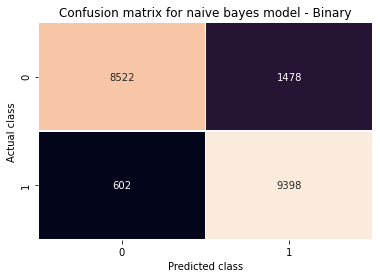

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     10000
           1       0.86      0.94      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [60]:
#1. Naive_Bayes
from sklearn.naive_bayes import MultinomialNB 
n_bayes1 = MultinomialNB(alpha = 1.0, fit_prior=True, class_prior=None) 

n_bayes1.fit(x_train, y_train)


#Metrics for naive bayes model - binary
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss, roc_curve
import seaborn as sns
print("The accuracy score for the train data is",accuracy_score(y_train, n_bayes1.predict(x_train)))
print("The accuracy score for the test data is",accuracy_score(y_test, n_bayes1.predict(x_test)))
print("="*75)
sns.heatmap(confusion_matrix(y_test, n_bayes1.predict(x_test)), linewidths=0.5, annot=True, fmt='d', cbar=False )
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for naive bayes model - Binary")
plt.show()
print("="*75)
print(classification_report(y_test, n_bayes1.predict(x_test)))

### 2nd Model - Logistic Regression with C = 1.0

The accuracy score for the train data is 1.0
The accuracy score for the test data is 0.9095


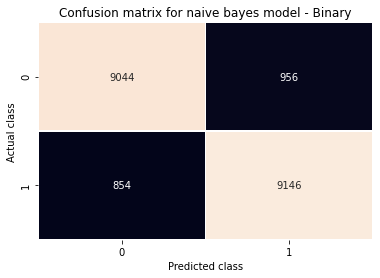

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     10000
           1       0.91      0.91      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [61]:
#1. logistic Regression (C = 1)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
log_reg1 = LogisticRegression(n_jobs=-1) #C = 1

log_reg1.fit(x_train, y_train)


#Metrics for naive bayes model - binary
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss, roc_curve
import seaborn as sns
print("The accuracy score for the train data is",accuracy_score(y_train, log_reg1.predict(x_train)))
print("The accuracy score for the test data is",accuracy_score(y_test, log_reg1.predict(x_test)))
print("="*75)
sns.heatmap(confusion_matrix(y_test, log_reg1.predict(x_test)), linewidths=0.5, annot=True, fmt='d', cbar=False )
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for naive bayes model - Binary")
plt.show()
print("="*75)
print(classification_report(y_test, log_reg1.predict(x_test)))

### 3. LogisticRegression (C = [0.01, 0.1, 1, 10, 100] )- Grid Search CV

In [62]:
#3. LogisticRegression (C = [0.01, 0.1, 1, 10, 100])
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
log_reg2 = LogisticRegression()
param = {"C":[0.01, 0.1, 1, 10]}
clf = GridSearchCV(estimator=log_reg2, param_grid=param, scoring="f1", n_jobs=-1, refit=True, error_score='raise')

clf.fit(x_train, y_train)

MemoryError: Unable to allocate 863. MiB for an array with shape (113075280,) and data type float64

In [ ]:
print("The best param for the grid serach cv model is",clf2.best_params_)
print("The best estimator is :-\n",clf2.best_estimator_)
print("The best score on the cv dataset is:",clf2.best_score_)
print("="*75)
print("The accuracy score on the CV dataset for 5 fold crossvalidation is :")
display((pd.DataFrame(clf2.cv_results_))[['param_C','mean_test_score']])
print("="*75)

#Metrics for Logistic Regression model - binary (using best found param)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss, roc_curve
import seaborn as sns
print("The accuracy score for the train data is",accuracy_score(y_train, clf2.predict(x_train)))
print("The accuracy score for the test data is",accuracy_score(y_test, clf2.predict(x_test)))
print("="*75)
sns.heatmap(confusion_matrix(y_test, clf2.predict(x_test)), linewidths=0.5, annot=True, fmt='d', cbar=False )
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for naive bayes model - Binary")
plt.show()
print("="*75)
print(classification_report(y_test, clf2.predict(x_test)))

## 2. Bag of words - Non binary

# 3 TFIDF Vectorizer

# 4. Word2Vec